In [150]:
import pandas as pd
import numpy as np
import os, yaml, json, sys, itertools
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('..')
from utility.scripts.tblogs_utility import get_results
from scipy.stats import wilcoxon
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

In [151]:
theoprodmax = 21_780*(1/6)
nrmsetormse = lambda x: x * theoprodmax / 100
rmsetonrmse = lambda x: x * 100 / theoprodmax

df = pd.DataFrame(
    columns=[
        'model_type',
        'lead_time',
        'location_amount',
        'locations',
        'best_epoch',
        'best_epoch_val_rmse',
        'best_epoch_val_mae',
    ]
)

poc_multiple:

In [152]:
basepath = "/home/masc12/dev/masc12-mthesis/poc_multiple/tblogs/" 
experiments = ['defaultmodel', 'pvinjection(late)', 'sunposmodel', 'gru_ln', 'latecombmodel', 'defaultaugmented', 'dm_weightedsampling.1+x**2', 'dm_weightedsampling.75+2x']
all_rows = []

for lead_time in [10, 20, 30, 40, 50, 60]:
    for model_type in experiments:
        for loc_type in ["singleloc", "multiloc"]:
            exp = os.path.join(basepath, f"fh{lead_time}-LitRsMultipleModel", model_type, loc_type)
            result_df = get_results(exp)
            for index, row in result_df.iterrows():
                new_row = {
                    'model_type': model_type,
                    'lead_time': lead_time,
                    'location_amount': row['location_amount'],
                    'locations': row['locations'],
                    'best_epoch': row['best_epoch'],
                }

                for key, value in row['best_epoch_metrics'].items():
                    new_row[key] = value

                all_rows.append(new_row)

poc_multihorizon:

In [153]:
basepath = "/home/masc12/dev/masc12-mthesis/poc_multihorizon/tblogs/lt10-multihorizon" 
mh_experiments = ['defaultmodel', 'extralstmteacherforcing', 'omnimodel']

for model_type in mh_experiments:
    for loc_type in ["singleloc", "multiloc"]:
        for fh in [0, 1, 2, 3, 4, 5]:
            exp = os.path.join(basepath, model_type, loc_type)
            result_df = get_results(exp, fh)
            for index, row in result_df.iterrows():
                new_row = {
                    'model_type':           "mh_"+model_type,
                    'lead_time':            (fh+1)*10,
                    'location_amount':      row['location_amount'],
                    'locations':            row['locations'],
                    'best_epoch':           row['best_epoch'],
                }

                for key, value in row['best_epoch_metrics'].items():
                    new_row[key] = value

                all_rows.append(new_row)

In [154]:
df = pd.DataFrame(all_rows)
df['locations'] = df['locations'].apply(tuple)
experiments = df["model_type"].unique()

In [155]:
# df.to_csv("results.csv", index=False, sep=",", encoding="utf-8")

In [156]:
palette = sns.color_palette() + sns.color_palette("tab20", n_colors=len(experiments))
colors_dict = {exp: palette[i] for i, exp in enumerate(experiments)}

In [157]:
import scienceplots
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
plt.style.use(['science'])
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/eval/plots"

# Forecast Horizon across Models

<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:46: SyntaxWarning: invalid escape sequence '\%'
<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:46: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_13785/985262016.py:34: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_ylabel("nRMSE [\%]")
/tmp/ipykernel_13785/985262016.py:46: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_ylabel("nMAE [\%]")
/tmp/ipykernel_13785/985262016.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


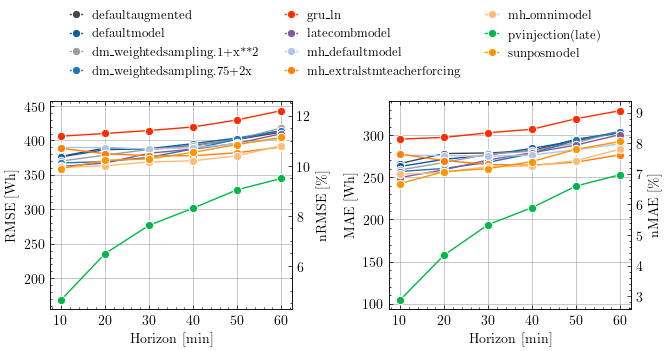

In [158]:
# Group by model_type and lead_time, compute mean, std, min, max
# grouped_summary = df[
#     df["model_type"] != "pvinjection(late)"
# ]
grouped_summary = df.groupby(['model_type', 'lead_time'])[
    ['total_rmse', 'total_mae']
].agg(['mean', 'min', 'max', 'std']).reset_index()

# grouped_summary = grouped_summary[(grouped_summary["model_type"] == "defaultmodel") | (grouped_summary["model_type"] == "sunposmodel")]

# Flatten columns
grouped_summary.columns = ['model_type', 'lead_time',
                           'rmse_mean', 'rmse_min', 'rmse_max', 'rmse_std',
                           'mae_mean', 'mae_min', 'mae_max', 'mae_std']




fig = plt.figure(figsize=(FIG_WIDTH, 3.5))  # total figure size
gs = gridspec.GridSpec(2, 2, height_ratios=[0.15, 0.85])  # top row = legend, bottom row = plots
gs.update(wspace=0.4)

axs = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1], sharex=fig.axes[0])]
# fig, axs = plt.subplots(1, 2, figsize=(FIG_WIDTH, 4), constrained_layout=True, sharex=True)


# Plot RMSE
sns.lineplot(data=grouped_summary, x="lead_time", y="rmse_mean", hue="model_type", marker="o", ax=axs[0], palette=colors_dict, legend=True)
axs[0].set_ylabel("RMSE [Wh]")	
axs[0].set_xlabel("Horizon [min]")

# add second y axis with nRMSE%
ax2 = axs[0].twinx()
ax2.set_ylabel("nRMSE [\%]")
yminrel = (axs[0].get_ylim()[0] / theoprodmax) * 100
ymaxrel = (axs[0].get_ylim()[1] / theoprodmax) * 100
ax2.set_ylim(yminrel, ymaxrel)

# Plot MAE
sns.lineplot(data=grouped_summary, x="lead_time", y="mae_mean", hue="model_type", marker="o", ax=axs[1], palette=colors_dict, legend=False)
axs[1].set_ylabel("MAE [Wh]")
axs[1].set_xlabel("Horizon [min]")

# add second y axis with nMAE%
ax2 = axs[1].twinx()
ax2.set_ylabel("nMAE [\%]")
yminrel = (axs[1].get_ylim()[0] / theoprodmax) * 100
ymaxrel = (axs[1].get_ylim()[1] / theoprodmax) * 100
ax2.set_ylim(yminrel, ymaxrel)


xticks = sorted(grouped_summary["lead_time"].unique())
plt.xticks(xticks)  # applies to current axes

for ax in axs:
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(xticks)


handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend_.remove()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.505, 1.00),bbox_transform=fig.transFigure, fontsize=9, handlelength=1, handleheight=1)

# SAVING
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/rmse_mae.png", dpi=300)
plt.show()

# Model Type Boxplot


<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_13785/1682933340.py:11: SyntaxWarning: invalid escape sequence '\%'
  ax.set_xlabel('nRMSE [\%]')


<Figure size 350x262.5 with 0 Axes>

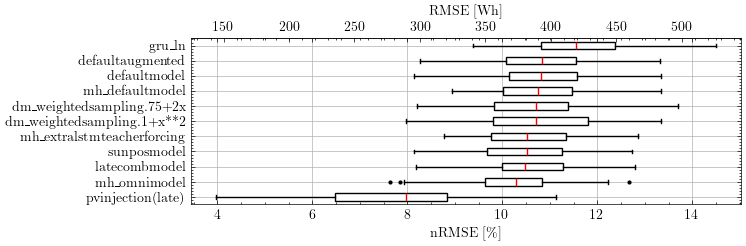

Top 10 Models:
        model_type  lead_time                    locations best_epoch  total_nrmse%  total_rmse  0_nrmse%  1_nrmse%  2_nrmse%
pvinjection(late)         10        (ebenalp, wiler-turm)         77      3.962751  143.847874  5.000551  3.251278  3.513270
pvinjection(late)         10          (ebenalp, kronberg)         77      4.022454  146.015072  5.275523  2.827485  3.659915
pvinjection(late)         10 (golfclub-erlen, wiler-turm)         65      4.150741  150.671892  5.015408  3.660746  3.418674
pvinjection(late)         10       (kronberg, wiler-turm)         75      4.162065  151.082977  4.887538  3.425374  3.831060
pvinjection(late)         10     (romanshorn, sitterdorf)         81      4.201640  152.519541  4.953860  3.573037  3.785874
pvinjection(late)         10 (golfclub-erlen, romanshorn)         75      4.213761  152.959507  5.117211  3.693464  3.448776
pvinjection(late)         10  (kronberg, rorschacherberg)         75      4.218718  153.139458  5.126324  3.3

In [159]:
# Clear previous plot
plt.clf()

dfsubset = df.copy()
median_per_model = dfsubset.groupby("model_type")["total_nrmse%"].median().sort_values()
sorted_models = median_per_model.index.tolist()
data_sorted = [dfsubset[dfsubset["model_type"] == m]['total_nrmse%'] for m in sorted_models]

fig, ax = plt.subplots(figsize=(FIG_WIDTH, 2.5))  # <-- FIX: define fig and ax

ax.set_xlabel('nRMSE [\%]')
ax.grid(True)
ax.set_axisbelow(True)

ax.boxplot(
    data_sorted,
    vert=False,
    patch_artist=True,
    tick_labels=sorted_models,
    boxprops=dict(facecolor='white', color='black'),
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markersize=2, markerfacecolor='black', linestyle='none'),
)

# Add second x-axis at top
secax = ax.secondary_xaxis('top', functions=(nrmsetormse, rmsetonrmse))
secax.set_xlabel('RMSE [Wh]')

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/models-nrmse-boxplot.png", dpi=300)	
plt.show()

top5 = dfsubset.nsmallest(10, 'total_nrmse%')[[
    'model_type', 'lead_time', 'locations', 'best_epoch', 'total_nrmse%', 'total_rmse', '0_nrmse%', '1_nrmse%', '2_nrmse%'
]]
print("Top 10 Models:\n", top5.to_string(index=False))


In [160]:
# print min mean max for each model
for model in sorted_models[::-1]:
    model_df = df[df["model_type"] == model]
    min_nrmse = model_df["total_nrmse%"].min()
    max_nrmse = model_df["total_nrmse%"].max()
    mean_nrmse = model_df["total_nrmse%"].median()
    print(f"{model}: min: {min_nrmse:.2f}, max: {max_nrmse:.2f}, mean: {mean_nrmse:.2f}")

gru_ln: min: 9.37, max: 14.50, mean: 11.56
defaultaugmented: min: 8.27, max: 13.32, mean: 10.84
defaultmodel: min: 8.13, max: 13.34, mean: 10.81
mh_defaultmodel: min: 8.93, max: 13.34, mean: 10.76
dm_weightedsampling.75+2x: min: 8.20, max: 13.70, mean: 10.71
dm_weightedsampling.1+x**2: min: 7.97, max: 13.35, mean: 10.70
mh_extralstmteacherforcing: min: 8.77, max: 12.86, mean: 10.52
sunposmodel: min: 8.14, max: 12.72, mean: 10.52
latecombmodel: min: 8.17, max: 12.79, mean: 10.49
mh_omnimodel: min: 7.64, max: 12.67, mean: 10.29
pvinjection(late): min: 3.96, max: 11.12, mean: 7.98


## significance of modeltype vs. baseline

In [161]:
# Pivot the dataframe to align model performance on (lead_time, locations)
pivot_df = df.pivot_table(
    index=['lead_time', 'locations'],
    columns='model_type',
    values='total_rmse',
    observed=False
)

# Extract defaultmodel's RMSE values
default_model_values = pivot_df['defaultmodel']

# Prepare list to store results
wilcoxon_results = []

# Loop through other models and perform Wilcoxon signed-rank test
for model in pivot_df.columns:
    if model == 'defaultmodel':
        continue

    other_model_values = pivot_df[model]

    # Perform paired Wilcoxon signed-rank test
    stat, p = wilcoxon(default_model_values, other_model_values)

    # Store the result
    wilcoxon_results.append({
        'model': model,
        'wilcoxon_stat': stat,
        'p_value': p
    })

# Create a DataFrame of results and sort by p-value
wilcoxon_df = pd.DataFrame(wilcoxon_results).sort_values('p_value')

In [162]:
rmse_diff = pivot_df.subtract(pivot_df['defaultmodel'], axis=0).mean() # Calculate the mean RMSE difference between each model and defaultmodel
nrmse_diff = {k: round(value/ theoprodmax * 100, 2) for k, value in rmse_diff.items()} # Calculate the nRMSE difference
wilcoxon_df['rmse_diff'] = wilcoxon_df['model'].map(rmse_diff) # Map the differences to the result DataFrame
wilcoxon_df['nrmse_diff_%'] = wilcoxon_df['model'].map(nrmse_diff) # Map the nRMSE differences to the result DataFrame
wilcoxon_df['better_or_worse'] = wilcoxon_df['rmse_diff'].apply(
    lambda x: 'better' if x < 0 else 'worse' if x > 0 else 'same' # Add 'better_or_worse' column based on RMSE difference
)
wilcoxon_df['significant_p<0.05'] = wilcoxon_df['p_value'] < 0.05
wilcoxon_df['significant_p<0.01'] = wilcoxon_df['p_value'] < 0.01
wilcoxon_df["p_value"] = wilcoxon_df["p_value"].apply(lambda x: f"{x:.2e}") # Format p-values in scientific notation

# order rows in the order of sorted_locations
wilcoxon_df['model_type'] = pd.Categorical(wilcoxon_df['model'], categories=sorted_models, ordered=True)
wilcoxon_df_sorted = wilcoxon_df.sort_values('model_type', ascending=False)
wilcoxon_df_sorted = wilcoxon_df_sorted.reset_index(drop=True)
wilcoxon_df_sorted

,model,wilcoxon_stat,p_value,rmse_diff,nrmse_diff_%,better_or_worse,significant_p<0.05,significant_p<0.01,model_type
0,gru_ln,2481.0,9.70e-24,26.622396,0.73,worse,True,True,gru_ln
1,defaultaugmented,11504.0,8.16e-01,-0.761603,-0.02,better,False,False,defaultaugmented
2,mh_defaultmodel,10332.0,1.32e-01,-1.574200,-0.04,better,False,False,mh_defaultmodel
3,dm_weightedsampling.75+2x,8415.0,3.28e-04,-7.919318,-0.22,better,True,True,dm_weightedsampling.75+2x
4,dm_weightedsampling.1+x**2,10620.0,2.32e-01,-2.763107,-0.08,better,False,False,dm_weightedsampling.1+x**2
5,mh_extralstmteacherforcing,6780.0,7.88e-08,-10.986799,-0.30,better,True,True,mh_extralstmteacherforcing
6,sunposmodel,5601.0,2.89e-11,-13.115672,-0.36,better,True,True,sunposmodel
7,latecombmodel,7438.0,3.25e-06,-9.959660,-0.27,better,True,True,latecombmodel
8,mh_omnimodel,3321.0,6.77e-20,-21.669547,-0.60,better,True,True,mh_omnimodel
9,pvinjection(late),0.0,3.43e-37,-117.926220,-3.25,better,True,True,pvinjection(late)


In [163]:
print(wilcoxon_df_sorted[["model", "p_value", "rmse_diff", "nrmse_diff_%", "better_or_worse", "significant_p<0.01"]].to_latex(index=False, escape=True, float_format="%.2f"))

\begin{tabular}{llrrlr}
\toprule
model & p\_value & rmse\_diff & nrmse\_diff\_\% & better\_or\_worse & significant\_p<0.01 \\
\midrule
gru\_ln & 9.70e-24 & 26.62 & 0.73 & worse & True \\
defaultaugmented & 8.16e-01 & -0.76 & -0.02 & better & False \\
mh\_defaultmodel & 1.32e-01 & -1.57 & -0.04 & better & False \\
dm\_weightedsampling.75+2x & 3.28e-04 & -7.92 & -0.22 & better & True \\
dm\_weightedsampling.1+x**2 & 2.32e-01 & -2.76 & -0.08 & better & False \\
mh\_extralstmteacherforcing & 7.88e-08 & -10.99 & -0.30 & better & True \\
sunposmodel & 2.89e-11 & -13.12 & -0.36 & better & True \\
latecombmodel & 3.25e-06 & -9.96 & -0.27 & better & True \\
mh\_omnimodel & 6.77e-20 & -21.67 & -0.60 & better & True \\
pvinjection(late) & 3.43e-37 & -117.93 & -3.25 & better & True \\
\bottomrule
\end{tabular}



# Pairwise Significance Matrix (Model Type)


In [164]:
# Prepare list to store results
n = len(sorted_models)
wilcoxon_results = [[0 for _ in range(n)] for _ in range(n)]
betterorworse = [[0 for _ in range(n)] for _ in range(n)]

In [165]:
# Prepare list to store results
n = len(sorted_models)
wilcoxon_results = [[0 for _ in range(n)] for _ in range(n)]
betterorworse = [[0 for _ in range(n)] for _ in range(n)]

model_pairs = itertools.combinations(sorted_models, 2)
for i in model_pairs:
    model1, model2 = i
    idx = sorted_models.index(model1)
    jdx = sorted_models.index(model2)

    stat, p = wilcoxon(pivot_df[model1], pivot_df[model2])
    wilcoxon_results[idx][jdx] = p
    wilcoxon_results[jdx][idx] = p

    pthresh = 0.01

    if p < pthresh:
        # significant: value of 1 indicates that model1 is better than model2
        if pivot_df[model1].mean() < pivot_df[model2].mean():
            # 1 is better than 2. 
            betterorworse[idx][jdx] = 1
            betterorworse[jdx][idx] = -1
        else:
            # 1 is worse than 2
            betterorworse[idx][jdx] = -1
            betterorworse[jdx][idx] = 1
    else:
        # not significant
        betterorworse[idx][jdx] = 0
        betterorworse[jdx][idx] = 0


df_full_wilcoxon = pd.DataFrame(wilcoxon_results, columns=sorted_models, index=sorted_models)
df_full_wilcoxon = df_full_wilcoxon.reindex(sorted_models[::-1], axis=1)
df_full_wilcoxon = df_full_wilcoxon.reindex(sorted_models[::-1], axis=0)


betterorworse = pd.DataFrame(betterorworse, columns=sorted_models, index=sorted_models)
betterorworse = betterorworse.reindex(sorted_models[::-1], axis=1)
betterorworse = betterorworse.reindex(sorted_models[::-1], axis=0)

df_full_wilcoxon

,gru_ln,defaultaugmented,defaultmodel,mh_defaultmodel,dm_weightedsampling.75+2x,dm_weightedsampling.1+x**2,mh_extralstmteacherforcing,sunposmodel,latecombmodel,mh_omnimodel,pvinjection(late)
gru_ln,0.000000e+00,8.911113e-25,9.696714e-24,1.505963e-23,2.385677e-29,2.984295e-22,4.690977e-29,2.461499e-33,3.641079e-31,4.958044e-34,3.427297e-37
defaultaugmented,8.911113e-25,0.000000e+00,8.159851e-01,7.140167e-01,1.071616e-03,6.292215e-01,1.020292e-05,7.879372e-11,9.800571e-06,4.792473e-16,3.427297e-37
defaultmodel,9.696714e-24,8.159851e-01,0.000000e+00,1.317618e-01,3.283877e-04,2.324748e-01,7.883533e-08,2.894026e-11,3.251791e-06,6.772800e-20,3.427297e-37
mh_defaultmodel,1.505963e-23,7.140167e-01,1.317618e-01,0.000000e+00,2.804710e-02,7.832224e-01,4.316766e-06,1.583778e-07,1.043128e-03,5.993023e-16,3.573659e-37
dm_weightedsampling.75+2x,2.385677e-29,1.071616e-03,3.283877e-04,2.804710e-02,0.000000e+00,4.023973e-03,2.333266e-01,3.502854e-03,3.087526e-01,2.557735e-10,3.427297e-37
dm_weightedsampling.1+x**2,2.984295e-22,6.292215e-01,2.324748e-01,7.832224e-01,4.023973e-03,0.000000e+00,9.433382e-04,5.800507e-06,1.588975e-03,5.241217e-16,3.427297e-37
mh_extralstmteacherforcing,4.690977e-29,1.020292e-05,7.883533e-08,4.316766e-06,2.333266e-01,9.433382e-04,0.000000e+00,1.945229e-01,4.537092e-01,4.368803e-08,8.698838e-37
sunposmodel,2.461499e-33,7.879372e-11,2.894026e-11,1.583778e-07,3.502854e-03,5.800507e-06,1.945229e-01,0.000000e+00,5.172343e-02,2.132918e-04,3.427297e-37
latecombmodel,3.641079e-31,9.800571e-06,3.251791e-06,1.043128e-03,3.087526e-01,1.588975e-03,4.537092e-01,5.172343e-02,0.000000e+00,2.942033e-08,3.475410e-37
mh_omnimodel,4.958044e-34,4.792473e-16,6.772800e-20,5.993023e-16,2.557735e-10,5.241217e-16,4.368803e-08,2.132918e-04,2.942033e-08,0.000000e+00,3.885278e-37


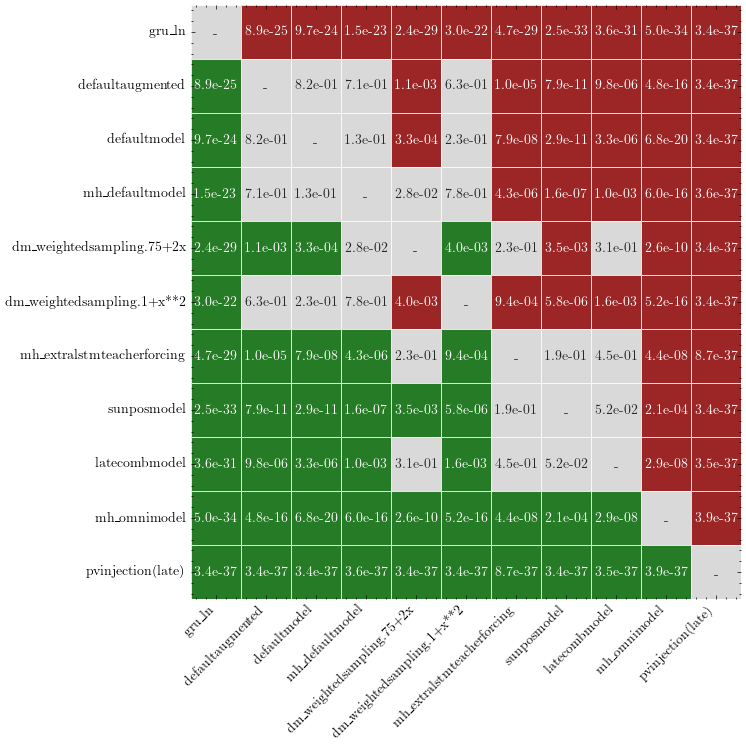

In [166]:
cmap = ListedColormap(['darkred', 'lightgrey', 'darkgreen'])
norm = BoundaryNorm([-1, 0, 1, 2], cmap.N)

df_plot = df_full_wilcoxon.map(lambda x: f"{x:.1e}" if x != 0 else "-")

plt.figure(figsize=(FIG_WIDTH, FIG_WIDTH))                         # tweak size to taste
sns.heatmap(
    data=betterorworse,
    cmap=cmap,
    norm=norm,
    annot=df_plot,
    fmt='',
    cbar=False,                               
    linewidths=0.5,
    linecolor='white',
    alpha=0.85
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# plt.title("Pairwise Wilcoxon p-values (cell text) with Sign. Better=Green, Worse=red")
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/heatmap-wilcoxon-pvalues.png", dpi=300)
plt.show()


In [167]:
# print(df_plot.to_latex(bold_rows=True, escape=True, float_format="%.2f"))

# Location Amount 2 vs. 1

## Boxplot

In [168]:
df.groupby(['model_type', 'location_amount'])[
    ['total_rmse', 'total_mae']
].agg({
    'total_rmse': ['mean', 'std', 'count'],
    'total_mae': ['mean', 'std']
}).reset_index().sort_values(('total_rmse', 'mean'), ascending=True)

model_type location_amount  total_rmse                   \
                                                      mean        std count   
19           pvinjection(late)               2  273.021098  62.132043   168   
18           pvinjection(late)               1  286.219805  62.769852    48   
17                mh_omnimodel               2  367.880731  32.243286   168   
11               latecombmodel               2  379.702649  32.750373   168   
21                 sunposmodel               2  380.462935  36.942881   168   
15  mh_extralstmteacherforcing               2  381.457196  33.707016   168   
20                 sunposmodel               1  381.820843  36.905222    48   
7    dm_weightedsampling.75+2x               2  383.739709  41.480198   168   
16                mh_omnimodel               1  387.366116  28.878719    48   
14  mh_extralstmteacherforcing               1  387.920856  29.460711    48   
5   dm_weightedsampling.1+x**2               2  388.296846  44.632280   168   
13             mh_defaultmodel               2  391.943263  35.964724   168   
1             defaultaugmented               2  392.572484  36.662365   168   
12             mh_defaultmodel               1  393.576321  32.501985    48   
6    dm_weightedsampling.75+2x               1  393.735723  33.694384    48   
3                 defaultmodel               2  393.879888  36.260830   168   
2                 defaultmodel               1  393.882031  34.869220    48   
0             defaultaugmented               1  395.030728  34.984794    48   
10               latecombmodel               1  398.683898  30.910365    48   
4   dm_weightedsampling.1+x**2               1  400.988693  38.451489    48   
9                       gru_ln               2  418.214149  38.056907   168   
8                       gru_ln               1  428.512899  37.918229    48   

     total_mae             
          mean        std  
19  191.963758  53.887715  
18  199.920215  54.483887  
17  263.101886  29.975693  
11  272.213315  33.518362  
21  267.838679  34.483229  
15  269.471469  30.815035  
20  265.195129  34.896860  
7   276.243597  39.281516  
16  270.306614  29.466230  
14  272.746693  23.444254  
5   278.829703  40.285738  
13  279.592431  30.920212  
1   284.207853  34.622852  
12  277.880753  30.396372  
6   279.057064  33.563063  
3   283.094968  33.865139  
2   277.396521  31.124726  
0   282.060020  35.614873  
10  282.310537  27.849171  
4   284.306997  33.538607  
9   307.932101  35.115904  
8   310.082184  36.991235

In [169]:
dfsubset = df.copy()
singles = [
    dfsubset[
        (dfsubset["model_type"] == mt) &
        (dfsubset["location_amount"] == 1)
    ]['total_nrmse%']
     for mt in df["model_type"].unique()]

pairs = [
    dfsubset[
        (dfsubset["model_type"] == mt) &
        (dfsubset["location_amount"] == 2)
    ]['total_nrmse%']
     for mt in df["model_type"].unique()]

<>:50: SyntaxWarning: invalid escape sequence '\%'
<>:50: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_13785/329136056.py:50: SyntaxWarning: invalid escape sequence '\%'
  ax.set_xlabel('nRMSE [\%]')


<Figure size 350x262.5 with 0 Axes>

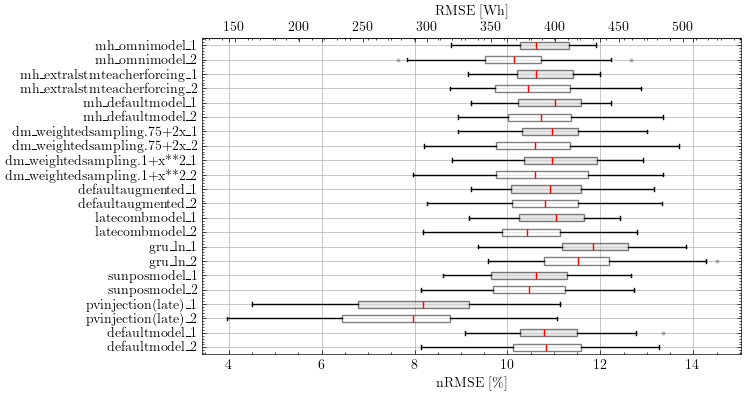

In [170]:
# Clear previous plot
plt.clf()
dfsubset = df.copy()
model_types = df["model_type"].unique()

boxplot_data = []
tick_labels = []
colors = []  # Store colors for each box

for mt in model_types:
    singles = dfsubset[
        (dfsubset["model_type"] == mt) &
        (dfsubset["location_amount"] == 1)
    ]['total_nrmse%']
    
    pairs = dfsubset[
        (dfsubset["model_type"] == mt) &
        (dfsubset["location_amount"] == 2)
    ]['total_nrmse%']

    if not pairs.empty:
        boxplot_data.append(pairs)
        tick_labels.append(f"{mt}_2")
        colors.append('white')  # color for pairs
    if not singles.empty:
        boxplot_data.append(singles)
        tick_labels.append(f"{mt}_1")
        colors.append('lightgrey')  # color for singles

# --- Plot ---
fig, ax = plt.subplots(figsize=(FIG_WIDTH, 4))  # Use subplots for better axis control
ax.grid(True)
ax.set_axisbelow(True)

box = ax.boxplot(
    boxplot_data,
    vert=False,
    patch_artist=True,
    tick_labels=tick_labels,
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markersize=2, markerfacecolor='black', linestyle='none', alpha=0.2),
)

# Apply colors to boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
    patch.set_edgecolor('black')

ax.set_xlabel('nRMSE [\%]')
secax = ax.secondary_xaxis('top', functions=(nrmsetormse, rmsetonrmse))
secax.set_xlabel("RMSE [Wh]")

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/models-2to1-nrmse-boxplot.png", dpi=300)
plt.show()


<>:38: SyntaxWarning: invalid escape sequence '\%'
<>:38: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_13785/3322588312.py:38: SyntaxWarning: invalid escape sequence '\%'
  plt.xlabel('nRMSE [\%]')


<Figure size 350x262.5 with 0 Axes>

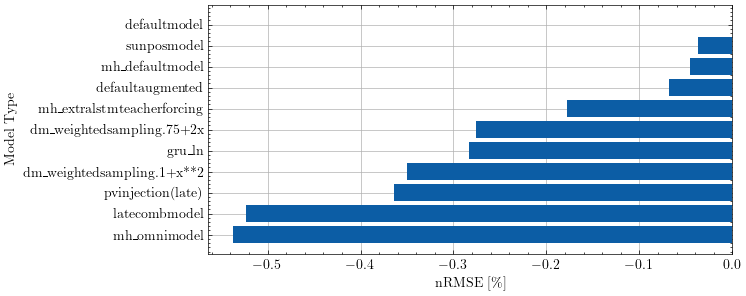

['mh_omnimodel', 'latecombmodel', 'pvinjection(late)', 'dm_weightedsampling.1+x**2', 'gru_ln', 'dm_weightedsampling.75+2x', 'mh_extralstmteacherforcing', 'defaultaugmented', 'mh_defaultmodel', 'sunposmodel', 'defaultmodel']
[-0.5367874641987171, -0.5228994273465624, -0.36360074790161967, -0.34963764963606536, -0.2837121108859062, -0.2753722772242, -0.17806226138801762, -0.06772020894682917, -0.04498782453653938, -0.037407957251227586, -5.9050734499521695e-05]


In [171]:
# barplot
plt.clf()
plt.figure(figsize=(FIG_WIDTH, 3))

# plt.title('Mean Improvement from 1\\textrightarrow 2 locations')

plt.grid(True)
plt.gca().set_axisbelow(True)

dfgrouped = df.groupby(['model_type', 'location_amount'])[['total_nrmse%']]\
    .agg({'total_nrmse%': ['mean', 'std', 'count']})\
    .reset_index()\
    .sort_values(('total_nrmse%', 'mean'), ascending=True)

labels = []
improvement = []
for model_type in df['model_type'].unique():
    two_loc = dfgrouped[(dfgrouped['model_type'] == model_type) & (dfgrouped['location_amount'] == 2)][('total_nrmse%', 'mean')]
    one_loc = dfgrouped[(dfgrouped['model_type'] == model_type) & (dfgrouped['location_amount'] == 1)][('total_nrmse%', 'mean')]
    
    if len(two_loc) != 1 and len(one_loc) != 1:
        raise ValueError(f"Expected single value for model_type {model_type}, got {two_loc} and {one_loc}")
    
    improvement.append(two_loc.values[0] - one_loc.values[0])
    labels.append(model_type)
    
# Sort labels and improvement based on improvement values
sorted_indices = np.argsort(improvement)
labels = [labels[i] for i in sorted_indices]
improvement = [improvement[i] for i in sorted_indices]
    
plt.barh(
    labels,
    improvement,
)

plt.ylabel('Model Type')
plt.xlabel('nRMSE [\%]')

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/models-2to1-mean-improvement-barplot.png", dpi=300)
plt.show()

print(labels)
print(improvement)

##  Significance

In [172]:
wilcoxon_results = []

for model in df["model_type"].unique():
    single = []
    pair = []
    for loc1, loc2 in df[df["location_amount"] == 2]["locations"].unique():
        for horizon in df["lead_time"].unique():
            single.append(df[
                (df["model_type"] == model) &
                (df["lead_time"] == horizon) &
                (
                    (df["locations"] == (loc1,)) |
                    (df["locations"] == (loc2,))
                )
            ]["total_rmse"].min())
            
            pair_val = df[
                (df["model_type"] == model) &
                (df["lead_time"] == horizon) &
                (df["location_amount"] == 2) &
                (df["locations"] == (loc1, loc2))
            ]["total_rmse"].values[0]
            if not pair_val:
                raise ValueError(f"Expected single value for model_type {model}, got {pair_val}")
            pair.append(pair_val)
    
    # perform wilcoxon test
    stat, p = wilcoxon(single, pair)
    
    wilcoxon_results.append({
        "model": model,
        "p_value": p,
        "wilcoxon_stat": stat,
        "rmse_diff": np.median(pair) - np.median(single),
        "nrmse_diff_%": (np.median(pair) - np.median(single)) / theoprodmax * 100,
    })
wilcoxon_df = pd.DataFrame(wilcoxon_results)

In [173]:
wilcoxon_df['better_or_worse'] = wilcoxon_df['rmse_diff'].apply(
    lambda x: 'better' if x < 0 else 'worse' if x > 0 else 'same' # Add 'better_or_worse' column based on RMSE difference
)
wilcoxon_df['significant_p<0.05'] = wilcoxon_df['p_value'] < 0.05
wilcoxon_df['significant_p<0.01'] = wilcoxon_df['p_value'] < 0.01
wilcoxon_df["p_value"] = wilcoxon_df["p_value"].apply(lambda x: f"{x:.2e}") # Format p-values in scientific notation

# order rows in the order of sorted_locations
wilcoxon_df['model_type'] = pd.Categorical(wilcoxon_df['model'], categories=sorted_models, ordered=True)
wilcoxon_df_sorted = wilcoxon_df.sort_values('model_type', ascending=False)
wilcoxon_df_sorted = wilcoxon_df_sorted.reset_index(drop=True)
wilcoxon_df_sorted

,model,p_value,wilcoxon_stat,rmse_diff,nrmse_diff_%,better_or_worse,significant_p<0.05,significant_p<0.01,model_type
0,gru_ln,8.63e-05,4619.0,9.564800,0.263493,worse,True,True,gru_ln
1,defaultaugmented,3.19e-10,3127.0,20.945263,0.577004,worse,True,True,defaultaugmented
2,defaultmodel,8.35e-12,2784.0,15.351640,0.422910,worse,True,True,defaultmodel
3,mh_defaultmodel,5.76e-08,3672.0,13.671348,0.376621,worse,True,True,mh_defaultmodel
4,dm_weightedsampling.75+2x,5.75e-05,4558.0,6.641044,0.182949,worse,True,True,dm_weightedsampling.75+2x
5,dm_weightedsampling.1+x**2,1.69e-03,5115.0,4.379971,0.120660,worse,True,True,dm_weightedsampling.1+x**2
6,mh_extralstmteacherforcing,1.18e-02,5509.0,6.600430,0.181830,worse,True,False,mh_extralstmteacherforcing
7,sunposmodel,9.12e-12,2792.0,24.297918,0.669364,worse,True,True,sunposmodel
8,latecombmodel,1.56e-01,6202.0,-4.646721,-0.128009,better,False,False,latecombmodel
9,mh_omnimodel,3.24e-01,6475.0,-6.052537,-0.166737,better,False,False,mh_omnimodel


In [174]:
print(wilcoxon_df_sorted[["model", "p_value", "rmse_diff", "nrmse_diff_%", "better_or_worse", "significant_p<0.01"]].to_latex(index=False, escape=True, float_format="%.2f"))

\begin{tabular}{llrrlr}
\toprule
model & p\_value & rmse\_diff & nrmse\_diff\_\% & better\_or\_worse & significant\_p<0.01 \\
\midrule
gru\_ln & 8.63e-05 & 9.56 & 0.26 & worse & True \\
defaultaugmented & 3.19e-10 & 20.95 & 0.58 & worse & True \\
defaultmodel & 8.35e-12 & 15.35 & 0.42 & worse & True \\
mh\_defaultmodel & 5.76e-08 & 13.67 & 0.38 & worse & True \\
dm\_weightedsampling.75+2x & 5.75e-05 & 6.64 & 0.18 & worse & True \\
dm\_weightedsampling.1+x**2 & 1.69e-03 & 4.38 & 0.12 & worse & True \\
mh\_extralstmteacherforcing & 1.18e-02 & 6.60 & 0.18 & worse & False \\
sunposmodel & 9.12e-12 & 24.30 & 0.67 & worse & True \\
latecombmodel & 1.56e-01 & -4.65 & -0.13 & better & False \\
mh\_omnimodel & 3.24e-01 & -6.05 & -0.17 & better & False \\
pvinjection(late) & 6.50e-02 & 0.33 & 0.01 & worse & False \\
\bottomrule
\end{tabular}



# best location / combination

<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_13785/3642274220.py:12: SyntaxWarning: invalid escape sequence '\%'
  ax.set_xlabel('nRMSE [\%]')


<Figure size 350x262.5 with 0 Axes>

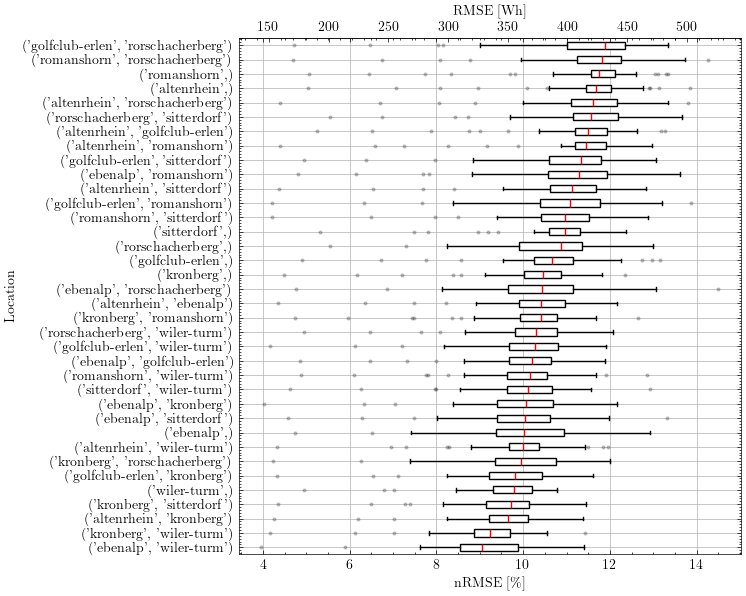

Top 10 Models:
        model_type  lead_time                    locations best_epoch  total_nrmse%  total_rmse  0_nrmse%  1_nrmse%  2_nrmse%
pvinjection(late)         10        (ebenalp, wiler-turm)         77      3.962751  143.847874  5.000551  3.251278  3.513270
pvinjection(late)         10          (ebenalp, kronberg)         77      4.022454  146.015072  5.275523  2.827485  3.659915
pvinjection(late)         10 (golfclub-erlen, wiler-turm)         65      4.150741  150.671892  5.015408  3.660746  3.418674
pvinjection(late)         10       (kronberg, wiler-turm)         75      4.162065  151.082977  4.887538  3.425374  3.831060
pvinjection(late)         10     (romanshorn, sitterdorf)         81      4.201640  152.519541  4.953860  3.573037  3.785874
pvinjection(late)         10 (golfclub-erlen, romanshorn)         75      4.213761  152.959507  5.117211  3.693464  3.448776
pvinjection(late)         10  (kronberg, rorschacherberg)         75      4.218718  153.139458  5.126324  3.3

In [175]:
# Clear previous plot
plt.clf()

dfsubset = df.copy()  # optionally filter model types here
median_per_location = dfsubset.groupby("locations")["total_nrmse%"].median().sort_values()
sorted_locations = median_per_location.index.tolist()
data_sorted = [dfsubset[dfsubset["locations"] == loc]['total_nrmse%'] for loc in sorted_locations]

# --- Set up plot and axis ---
fig, ax = plt.subplots(figsize=(FIG_WIDTH, 6))

ax.set_xlabel('nRMSE [\%]')
ax.set_ylabel('Location')
ax.grid(True)
ax.set_axisbelow(True)

ax.boxplot(
    data_sorted,
    vert=False,
    patch_artist=True,
    tick_labels=sorted_locations,
    boxprops=dict(facecolor='white', color='black'),
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markersize=2, markerfacecolor='black', linestyle='none', alpha=0.2),
)

secax = ax.secondary_xaxis('top', functions=(nrmsetormse, rmsetonrmse))
secax.set_xlabel('RMSE [Wh]')

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/locations-boxplot.png", dpi=300)
plt.show()

# --- Top 10 models ---
top5 = dfsubset.nsmallest(10, 'total_nrmse%')[
    ['model_type', 'lead_time', 'locations', 'best_epoch', 'total_nrmse%', 'total_rmse', '0_nrmse%', '1_nrmse%', '2_nrmse%']
]
print("Top 10 Models:\n", top5.to_string(index=False))


In [176]:
dfcopy = df.explode('locations')
dfcopy['locations'] = dfcopy['locations'].str.strip()
agg_df = dfcopy.groupby(['model_type', 'locations'])['total_nrmse%'].mean().reset_index()
agg_df['rank_within_model'] = agg_df.groupby('model_type')['total_nrmse%'].rank(method='min', ascending=True)
agg_df['reciprocal_rank'] = 1 / agg_df['rank_within_model']
mrr_per_location = agg_df.groupby('locations')['reciprocal_rank'].mean().sort_values(ascending=False)
print("MRR per location (based on location rank within each model type):")
print(mrr_per_location)


MRR per location (based on location rank within each model type):
locations
wiler-turm         0.757576
kronberg           0.606061
ebenalp            0.469697
sitterdorf         0.228788
golfclub-erlen     0.205411
altenrhein         0.166234
romanshorn         0.143398
rorschacherberg    0.140693
Name: reciprocal_rank, dtype: float64


# Comparison to Existing Forecast Models

In [177]:
# Identify best locations per model type (lowest total_rmse across all lead_times)
bestlocs = {}
for m in df["model_type"].unique():
    # Aggregate over all lead_times for fair comparison
    best = df[df["model_type"] == m].groupby("locations")["total_rmse"].mean().sort_values()
    bestlocs[m] = best.index[0]

# Filter df to include only best location for each model
filtered_df = pd.concat([
    df[(df["model_type"] == m) & (df["locations"] == bestlocs[m])]
    for m in bestlocs
])

# Create grouped summary with min RMSE/MAE per horizon per model
grouped_summary = filtered_df.groupby(["lead_time", "model_type"]).agg(
    rmse_min=('total_rmse', 'min'),
    mae_min=('total_mae', 'min')
).reset_index()

In [178]:
bestlocs

{'defaultmodel': ('ebenalp', 'wiler-turm'),
 'pvinjection(late)': ('kronberg', 'sitterdorf'),
 'sunposmodel': ('kronberg', 'wiler-turm'),
 'gru_ln': ('wiler-turm',),
 'latecombmodel': ('ebenalp', 'wiler-turm'),
 'defaultaugmented': ('kronberg', 'wiler-turm'),
 'dm_weightedsampling.1+x**2': ('kronberg', 'wiler-turm'),
 'dm_weightedsampling.75+2x': ('ebenalp', 'wiler-turm'),
 'mh_defaultmodel': ('golfclub-erlen', 'kronberg'),
 'mh_extralstmteacherforcing': ('ebenalp', 'wiler-turm'),
 'mh_omnimodel': ('ebenalp', 'wiler-turm')}

<>:16: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
<>:16: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_13785/3621604508.py:16: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_ylabel("nRMSE [\%]")
/tmp/ipykernel_13785/3621604508.py:28: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_ylabel("nMAE [\%]")


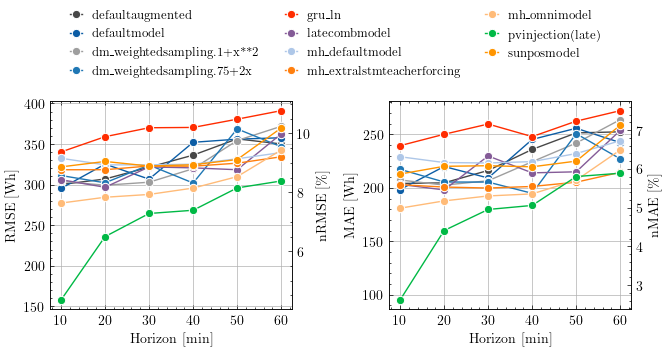

In [179]:
fig = plt.figure(figsize=(FIG_WIDTH, 3.5))  # total figure size
gs = gridspec.GridSpec(2, 2, height_ratios=[0.15, 0.85])  # top row = legend, bottom row = plots
gs.update(wspace=0.4)

axs = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1], sharex=fig.axes[0])]
# fig, axs = plt.subplots(1, 2, figsize=(FIG_WIDTH, 4), constrained_layout=True, sharex=True)


# Plot RMSE
sns.lineplot(data=grouped_summary, x="lead_time", y="rmse_min", hue="model_type", marker="o", ax=axs[0], palette=colors_dict, legend=True)
axs[0].set_ylabel("RMSE [Wh]")	
axs[0].set_xlabel("Horizon [min]")

# add second y axis with nRMSE%
ax2 = axs[0].twinx()
ax2.set_ylabel("nRMSE [\%]")
yminrel = (axs[0].get_ylim()[0] / theoprodmax) * 100
ymaxrel = (axs[0].get_ylim()[1] / theoprodmax) * 100
ax2.set_ylim(yminrel, ymaxrel)

# Plot MAE
sns.lineplot(data=grouped_summary, x="lead_time", y="mae_min", hue="model_type", marker="o", ax=axs[1], palette=colors_dict, legend=False)
axs[1].set_ylabel("MAE [Wh]")
axs[1].set_xlabel("Horizon [min]")

# add second y axis with nMAE%
ax2 = axs[1].twinx()
ax2.set_ylabel("nMAE [\%]")
yminrel = (axs[1].get_ylim()[0] / theoprodmax) * 100
ymaxrel = (axs[1].get_ylim()[1] / theoprodmax) * 100
ax2.set_ylim(yminrel, ymaxrel)


xticks = sorted(grouped_summary["lead_time"].unique())
plt.xticks(xticks)  # applies to current axes

for ax in axs:
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(xticks)


handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend_.remove()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.505, 1.00),bbox_transform=fig.transFigure, fontsize=9, handlelength=1, handleheight=1)

# SAVING
# plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/horizon-min-rmse_mae.png", dpi=300)
plt.show()

boxplot forecast horizon

In [180]:
m = "pvinjection(late)"
dfsubset[(dfsubset["model_type"] == m)& (df["locations"] == bestlocs[m])]['total_nrmse%']

64      4.347475
352     6.498412
640     7.283744
928     7.393582
1216    8.151855
1504    8.387530
Name: total_nrmse%, dtype: float64

<>:16: SyntaxWarning: invalid escape sequence '\%'
<>:16: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_13785/3272238564.py:16: SyntaxWarning: invalid escape sequence '\%'
  ax.set_xlabel('nRMSE [\%]')


<Figure size 350x262.5 with 0 Axes>

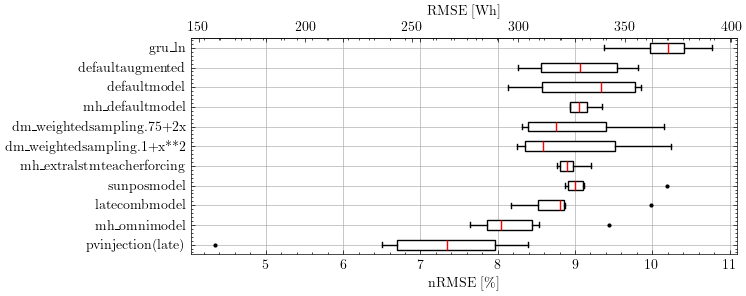

In [181]:
# Clear previous plot
plt.clf()

dfsubset = df.copy()
median_per_model = dfsubset.groupby("model_type")["total_nrmse%"].median().sort_values()
sorted_models = median_per_model.index.tolist()

data_sorted = [
    dfsubset[(dfsubset["model_type"] == m) & (dfsubset["locations"] == bestlocs[m])]['total_nrmse%'] 
    for m in sorted_models
]

# --- Set up plot and axis ---
fig, ax = plt.subplots(figsize=(FIG_WIDTH, 3))

ax.set_xlabel('nRMSE [\%]')
ax.grid(True)
ax.set_axisbelow(True)

ax.boxplot(
    data_sorted,
    vert=False,
    showfliers=True,
    tick_labels=sorted_models,
    patch_artist=True,
    boxprops=dict(facecolor='white', color='black'),
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markersize=2, markerfacecolor='black', linestyle='none'),
)

secax = ax.secondary_xaxis('top', functions=(nrmsetormse, rmsetonrmse))
secax.set_xlabel('RMSE [Wh]')

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/models-min-nrmse-boxplot.png", dpi=300)
plt.show()
